In [302]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


pd.set_option("display.max_rows", 100)

In [34]:
users = pd.read_csv("takehome_users.csv",encoding = "ISO-8859-1")
engagement = pd.read_csv("takehome_user_engagement.csv",encoding = "ISO-8859-1")

In [250]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [35]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [36]:
engagement = engagement.sort_values(by='time_stamp')

In [61]:
engagement.head()

,time_stamp,user_id,visited
178140,2012-05-31 08:20:06,10012,1
59486,2012-05-31 15:47:36,3428,1
175638,2012-05-31 17:19:37,9899,1
26821,2012-05-31 21:58:33,1693,1
109716,2012-06-01 00:17:30,6102,1


In [44]:
#timeperiod we are dealing with
min(engagement['time_stamp']), max(engagement['time_stamp'])

('2012-05-31 08:20:06', '2014-06-06 14:58:50')

In [68]:
#unique users
engagement['user_id'].nunique()

8823

In [202]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp']) - pd.to_timedelta(7, unit='d')
df =pd.DataFrame(engagement.groupby(['user_id',pd.Grouper(key='time_stamp',freq='W-MON')])['visited'].sum())
df = df.reset_index()

In [203]:
df.head(20)

,user_id,time_stamp,visited
0,1,2014-03-17,1
1,2,2013-10-07,1
2,2,2013-10-21,1
3,2,2013-10-28,1
4,2,2013-11-18,1
5,2,2013-11-25,1
6,2,2013-12-02,1
7,2,2013-12-23,1
8,2,2013-12-30,2
9,2,2014-01-06,2


In [204]:
df.shape

(68796, 3)

In [205]:
active_user = df.groupby(['user_id'])['visited'].max()[df.groupby(['user_id'])['visited'].max() >=3].index

We can pull metrics such as 
1. Total number of visits
2. Average number of visits per week (maybe DATE LEAKAGE)
3. Max number of visits in a week (DATA LEAKAGE)
4. Weeks with 0 visits
5. Number of weeks active (1 or more logins)
6. % of weeks active
7. time_span (last login week - first login week)

In [208]:
total_visits = df.groupby('user_id')['visited'].sum()
time_span = (pd.TimedeltaIndex(df.groupby('user_id')['time_stamp'].max() - df.groupby('user_id')['time_stamp'].min()).days)/7 + 1
weeks_with_no_visit = time_span - df.groupby('user_id')['visited'].count()
weeks_active = df.groupby('user_id')['visited'].count()
PCT_weeks_active = weeks_active/time_span
active = 

In [187]:
PCT_weeks_active

user_id
1        1.0
2        0.6
3        1.0
4        1.0
5        1.0
        ... 
11996    1.0
11997    1.0
11998    1.0
11999    1.0
12000    1.0
Length: 8823, dtype: float64

In [209]:
len(total_visits),len(time_span), len(weeks_with_no_visit), len(PCT_weeks_active)

(8823, 8823, 8823, 8823)

In [254]:
df = pd.DataFrame({'user_id':total_visits.index,
                  'total_visits':total_visits,
                  'time_span':time_span,
                  'weeks_with_no_visit':weeks_with_no_visit,
                  'weeks_active':weeks_active,
                  'PCT_weeks_active':PCT_weeks_active,
                  })

In [255]:
df.head()

,user_id,total_visits,time_span,weeks_with_no_visit,weeks_active,PCT_weeks_active
user_id,,,,,,
1,1,1,1.0,0.0,1,1.0
2,2,14,20.0,8.0,12,0.6
3,3,1,1.0,0.0,1,1.0
4,4,1,1.0,0.0,1,1.0
5,5,1,1.0,0.0,1,1.0


In [256]:
df.isnull().sum()

user_id                0
total_visits           0
time_span              0
weeks_with_no_visit    0
weeks_active           0
PCT_weeks_active       0
dtype: int64

In [257]:
df = pd.merge(left = df, right = users, left_on=df['user_id'],right_on=users['object_id'])

In [258]:
df.head()

,key_0,user_id,total_visits,time_span,weeks_with_no_visit,weeks_active,PCT_weeks_active,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,1,1.0,0.0,1,1.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2,14,20.0,8.0,12,0.6,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3,1,1.0,0.0,1,1.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,4,1,1.0,0.0,1,1.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,5,1,1.0,0.0,1,1.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [259]:
df.drop(['key_0'],axis=1, inplace=True)

In [260]:
df['active'] = df['user_id'].apply(lambda x: 1 if x in active_user else 0)

In [261]:
df[df['active']!=0].head()

,user_id,total_visits,time_span,weeks_with_no_visit,weeks_active,PCT_weeks_active,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
7,10,284,73.0,0.0,73,1.000000,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1
13,20,7,12.0,9.0,3,0.250000,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,1
28,42,342,80.0,4.0,76,0.950000,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN,1
29,43,8,15.0,10.0,5,0.333333,43,2012-12-31 07:13:17,Gomes Beatrice,vgqmpljq@yyyxt.com,GUEST_INVITE,1.366010e+09,0,0,63,149.0,1
38,53,9,12.0,6.0,6,0.500000,53,2013-02-09 23:47:15,Ribeiro Camila,CamilaGomesRibeiro@gmail.com,GUEST_INVITE,1.367798e+09,0,0,37,3641.0,1


In [262]:
df.isnull().sum()

user_id                          0
total_visits                     0
time_span                        0
weeks_with_no_visit              0
weeks_active                     0
PCT_weeks_active                 0
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
active                           0
dtype: int64

In [263]:
df['invited_by_user'] = df['invited_by_user_id'].apply(lambda x: 0 if math.isnan(x) else 1)

In [264]:
df[df['invited_by_user_id'].isnull()==True].head()

,user_id,total_visits,time_span,weeks_with_no_visit,weeks_active,PCT_weeks_active,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,invited_by_user
6,7,1,1.0,0.0,1,1.00,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0,0
8,11,1,1.0,0.0,1,1.00,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,1.388117e+09,0,0,69,NaN,0,0
10,14,1,1.0,0.0,1,1.00,14,2012-10-11 16:14:33,Rivera Bret,BretKRivera@gmail.com,SIGNUP,1.350058e+09,0,0,0,NaN,0,0
12,19,2,2.0,0.0,2,1.00,19,2013-05-24 14:56:36,Collins Arlene,ArleneRCollins@gmail.com,SIGNUP,1.369926e+09,1,0,0,NaN,0,0
13,20,7,12.0,9.0,3,0.25,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,1,0


In [265]:
df.drop(['name','email','org_id','invited_by_user_id'],axis=1, inplace=True)

In [266]:
df.head()

,user_id,total_visits,time_span,weeks_with_no_visit,weeks_active,PCT_weeks_active,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,active,invited_by_user
0,1,1,1.0,0.0,1,1.0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,0,1
1,2,14,20.0,8.0,12,0.6,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,0,1
2,3,1,1.0,0.0,1,1.0,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,0,1
3,4,1,1.0,0.0,1,1.0,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,0,1
4,5,1,1.0,0.0,1,1.0,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,0,1


In [267]:
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [272]:
df['last_session_creation_time'] = df['last_session_creation_time'].astype(int).astype("datetime64[s]")

In [288]:
df.head()

,total_visits,time_span,weeks_active,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,active,invited_by_user,last_minus_creation
0,1,1.0,1,GUEST_INVITE,1,0,0,1,0
1,14,20.0,12,ORG_INVITE,0,0,0,1,136
2,1,1.0,1,ORG_INVITE,0,0,0,1,0
3,1,1.0,1,GUEST_INVITE,0,0,0,1,1
4,1,1.0,1,GUEST_INVITE,0,0,0,1,5


In [280]:
df['last_minus_creation'] = pd.TimedeltaIndex(df['last_session_creation_time'] - df['creation_time']).days

In [287]:
df.drop(['creation_time','last_session_creation_time'],axis=1,inplace=True)
df.drop(['PCT_weeks_active'],axis=1,inplace=True)
df.drop(['user_id','weeks_with_no_visit','object_id'],axis=1,inplace=True)

In [290]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['active'],axis=1), df['active'], test_size=0.2, shuffle=True, stratify=df['active'])

In [291]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7058, 1765, 7058, 1765)

In [292]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [293]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train_np = scaler.transform(X_train)
X_test_np = scaler.transform(X_test)

In [294]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [296]:
confusion_matrix(y_test, pred)

array([[1463,   13],
       [  17,  272]], dtype=int64)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

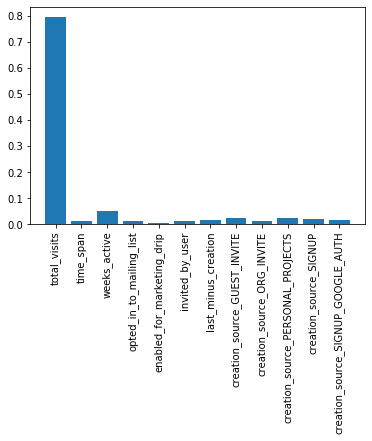

In [301]:
plt.bar(X_train.columns, clf.feature_importances_)
plt.xticks(rotation=90)

In [303]:
accuracy_score(y_test,pred)

0.9830028328611898

We have achieved 98% accuracy on our test data and the most import attribute is total number of visits followed by wnumber of weeks active.